<a href="https://colab.research.google.com/github/fakhia/gene-expression-breast-cancer-analysis/blob/main/HackBio_Surprise_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install biopython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 39.7 MB/s eta 0:00:00


Loaded url1: shape=(569, 33), columns=['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean']
Loaded url2: shape=(12, 7), columns=['Unnamed: 0', 'HBR_1', 'HBR_2', 'HBR_3', 'UHR_1', 'UHR_2', 'UHR_3']
Loaded url3: shape=(971, 5), columns=['name', 'log2FoldChange', 'PAdj', '-log10PAdj', 'significance']

Auto-detection results:
counts_df: found url2
deg_df: found url3
bc_df: found url1

Plotting heatmap from detected counts file (columns: ['Unnamed: 0', 'HBR_1', 'HBR_2', 'HBR_3', 'UHR_1', 'UHR_2', 'UHR_3'])


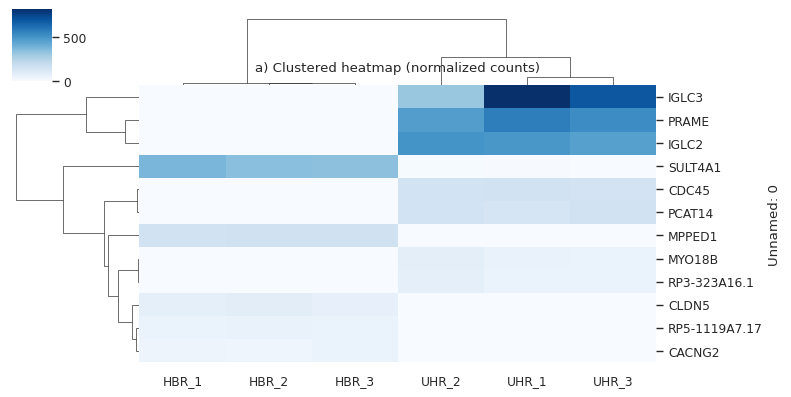

Saved figure_a.png

Plotting volcano from detected DEG file (columns: ['name', 'log2FoldChange', 'PAdj', '-log10PAdj', 'significance'])


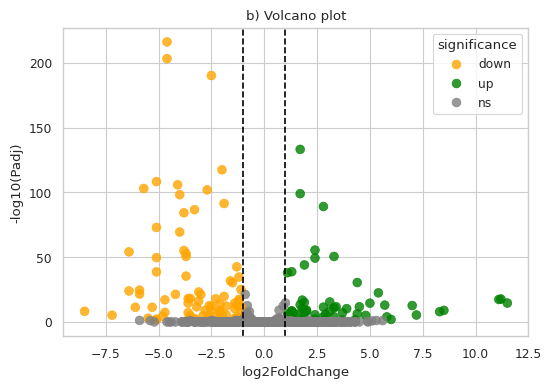

Saved figure_b.png
Auto-renamed bc columns: {'radius_mean': 'radius_mean', 'texture_mean': 'texture_mean', 'perimeter_mean': 'perimeter_mean', 'area_mean': 'area_mean', 'smoothness_mean': 'smoothness_mean', 'compactness_mean': 'compactness_mean'}


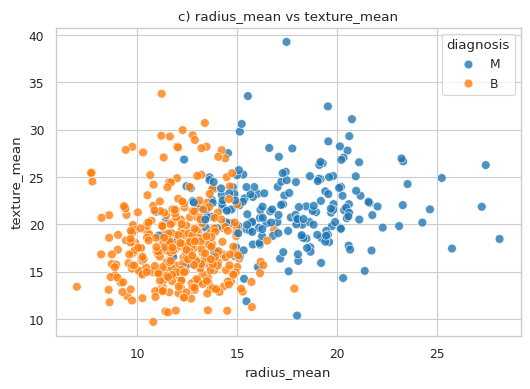

Saved figure_c.png


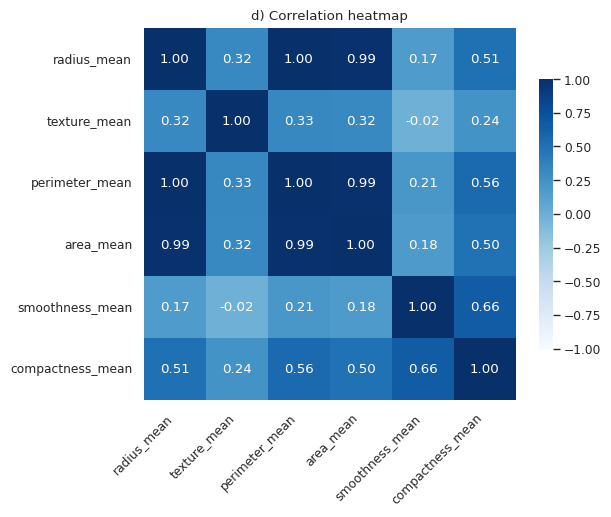

Saved figure_d.png


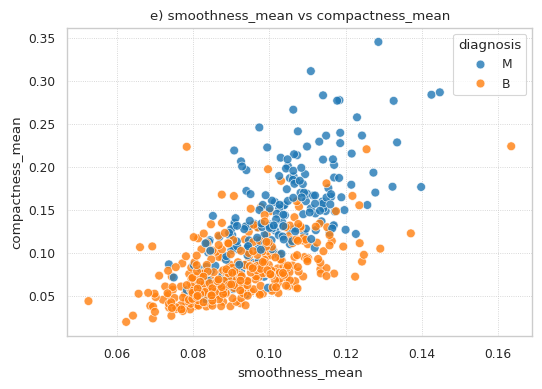

Saved figure_e.png


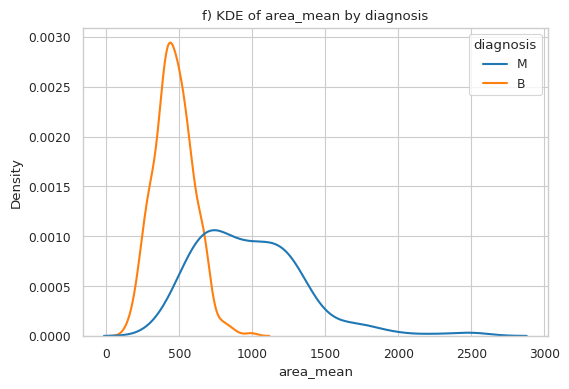

Saved figure_f.png

All plots saved to /content/figures
You can download them via the Files panel in Colab or use from google.colab import files; files.download(path).


In [4]:
# Colab-ready: reproduce Figures 1A-F using the provided GitHub CSVs
# Paste into one cell and run.

import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import gaussian_kde
from urllib.request import urlopen

sns.set(style="whitegrid", context="paper", font_scale=1.0)
OUT_DIR = "/content/figures"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- URLs (from your message) ----
url1 = "https://raw.githubusercontent.com/HackBio-Internship/2025_project_collection/refs/heads/main/Python/Dataset/data-3.csv"
url2 = "https://raw.githubusercontent.com/HackBio-Internship/2025_project_collection/refs/heads/main/Python/Dataset/hbr_uhr_top_deg_normalized_counts.csv"
url3 = "https://raw.githubusercontent.com/HackBio-Internship/2025_project_collection/refs/heads/main/Python/Dataset/hbr_uhr_deg_chr22_with_significance.csv"

urls = {
    "url1": url1,
    "url2": url2,
    "url3": url3
}

# ---- helper: load CSV from URL robustly ----
def load_csv_from_url(url):
    try:
        raw = urlopen(url).read().decode('utf-8')
        # try automatic separator inference
        df = pd.read_csv(io.StringIO(raw), sep=None, engine='python')
    except Exception:
        # fallback to simple comma
        df = pd.read_csv(io.StringIO(raw))
    return df

# load them and store with basic diagnostics
dfs = {}
for k,u in urls.items():
    try:
        df = load_csv_from_url(u)
        dfs[k] = df
        print(f"Loaded {k}: shape={df.shape}, columns={list(df.columns)[:8]}")
    except Exception as e:
        print(f"Failed to load {k} from {u}: {e}")

# ---- Auto-detect roles for files ----
counts_df = None   # normalized counts (heatmap)
deg_df = None      # differential expression results (volcano)
bc_df = None       # breast cancer style data (c-f) OR alternative dataset with those columns

for name, df in dfs.items():
    cols_lower = [str(c).lower() for c in df.columns]
    # detect DEG-like: presence of log2FoldChange or padj
    if any('log2fold' in c for c in cols_lower) or any('padj' in c for c in cols_lower) or any('padj' in c for c in cols_lower):
        deg_df = df.copy()
        deg_name = name
    # detect counts-like: many numeric columns and first col looks like gene
    elif df.shape[1] >= 3 and (not np.issubdtype(df.iloc[:,0].dtype, np.number) or 'gene' in cols_lower[0]):
        counts_df = df.copy()
        counts_name = name
    # detect breast-cancer-style: presence of radius_mean or area_mean etc.
    if any('radius_mean' in c for c in cols_lower) or any('area_mean' in c for c in cols_lower):
        bc_df = df.copy()
        bc_name = name

# If still None, try alternate heuristics
if counts_df is None:
    # if one file has 'HBR' or 'UHR' in column names choose that
    for name, df in dfs.items():
        if any('hbr' in str(c).lower() or 'uhr' in str(c).lower() for c in df.columns):
            counts_df = df.copy()
            counts_name = name
            break

if deg_df is None:
    # pick the file named with chr22 in url (likely url3)
    if 'url3' in dfs:
        deg_df = dfs['url3'].copy()
        deg_name = 'url3'

if bc_df is None:
    # if nothing else, test url1 as bc candidate
    if 'url1' in dfs:
        bc_df = dfs['url1'].copy()
        bc_name = 'url1'

print("\nAuto-detection results:")
print("counts_df:", 'found' if counts_df is not None else 'NOT found', getattr(locals().get('counts_name', None), '__str__', lambda: '')())
print("deg_df:", 'found' if deg_df is not None else 'NOT found', getattr(locals().get('deg_name', None), '__str__', lambda: '')())
print("bc_df:", 'found' if bc_df is not None else 'NOT found', getattr(locals().get('bc_name', None), '__str__', lambda: '')())

# ---- Helper plotting functions ----
def ensure_gene_index(df):
    """If first column holds gene names (non-numeric), set as index."""
    dfc = df.copy()
    first_col = dfc.columns[0]
    if not np.issubdtype(dfc[first_col].dtype, np.number):
        # set as index safely
        dfc = dfc.set_index(first_col)
    return dfc

def plot_heatmap_counts(df_counts, sample_cols=None, top_n=50, figsize=(8,4), outpath=None):
    # prepare index if needed
    dfc = ensure_gene_index(df_counts)
    # choose sample columns: if provided, ensure they exist
    if sample_cols is None:
        # drop any non-numeric columns (if index is gene names now)
        numeric_cols = [c for c in dfc.columns if np.issubdtype(dfc[c].dtype, np.number)]
        sample_cols = numeric_cols
    dfc = dfc[sample_cols].astype(float)
    # pick top variable genes for display
    top_genes = dfc.var(axis=1).sort_values(ascending=False).head(min(top_n, dfc.shape[0])).index
    dfc_top = dfc.loc[top_genes]
    # cluster and plot clustermap via seaborn for nicer dendrogram + heatmap
    cg = sns.clustermap(dfc_top, cmap="Blues", figsize=figsize, row_cluster=True, col_cluster=True,
                        yticklabels=True, xticklabels=True)
    cg.ax_heatmap.set_title("a) Clustered heatmap (normalized counts)", pad=10)
    if outpath:
        cg.savefig(outpath, dpi=150)
    plt.show()
    plt.close()

def plot_volcano(deg_df, lfc_cols_candidates=None, padj_candidates=None, lfc_cut=1.0, padj_cut=0.05, outpath=None):
    df = deg_df.copy()
    # detect column names for LFC and padj
    col_lfc = None
    col_padj = None
    lcands = lfc_cols_candidates or ['log2foldchange','log2fold','log2fc','log2_fc','lfc','log2FoldChange','log2FoldChange']
    pcands = padj_candidates or ['padj','adj_pval','fdr','adj.p.val','p_adj','p.adjust','qvalue']
    cols_lower = {c.lower():c for c in df.columns}
    for cand in lcands:
        if cand.lower() in cols_lower:
            col_lfc = cols_lower[cand.lower()]
            break
    for cand in pcands:
        if cand.lower() in cols_lower:
            col_padj = cols_lower[cand.lower()]
            break
    # if not found, try common alternatives
    if col_lfc is None:
        # try any column that contains 'log2' and 'fold' or 'fc'
        for c in df.columns:
            if 'log2' in c.lower() and ('fold' in c.lower() or 'fc' in c.lower()):
                col_lfc = c
                break
    if col_padj is None:
        for c in df.columns:
            if 'padj' in c.lower() or 'adj' in c.lower() or 'fdr' in c.lower():
                col_padj = c
                break
    if col_lfc is None or col_padj is None:
        print("Could not auto-detect LFC/padj columns. Columns available:", list(df.columns)[:40])
        raise ValueError("Please ensure DEG file contains columns for log2FoldChange and padj (adjusted p-value).")

    df['neglog10padj'] = -np.log10(df[col_padj].replace(0, np.nextafter(0,1)))
    df['sig'] = 'ns'
    df.loc[(df[col_padj] < padj_cut) & (df[col_lfc] > lfc_cut), 'sig'] = 'up'
    df.loc[(df[col_padj] < padj_cut) & (df[col_lfc] < -lfc_cut), 'sig'] = 'down'

    palette = {'up':'green','down':'orange','ns':'gray'}
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=col_lfc, y='neglog10padj', hue='sig', palette=palette, alpha=0.8, edgecolor=None, s=40)
    plt.axvline(-lfc_cut, linestyle='--', color='black')
    plt.axvline(lfc_cut, linestyle='--', color='black')
    plt.xlabel("log2FoldChange")
    plt.ylabel("-log10(Padj)")
    plt.title("b) Volcano plot")
    plt.legend(title="significance")
    if outpath:
        plt.savefig(outpath, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

# ---- Prepare and plot ----
# Part A: heatmap (counts_df) and volcano (deg_df)
if counts_df is not None:
    print(f"\nPlotting heatmap from detected counts file (columns: {list(counts_df.columns)[:10]})")
    try:
        plot_heatmap_counts(counts_df, top_n=50, outpath=os.path.join(OUT_DIR, "figure_a.png"))
        print("Saved figure_a.png")
    except Exception as e:
        print("Heatmap plotting failed:", e)
else:
    print("\nNo counts_df detected. If you intended to use a specific file as normalized counts, please upload or rename.")

if deg_df is not None:
    print(f"\nPlotting volcano from detected DEG file (columns: {list(deg_df.columns)[:10]})")
    try:
        plot_volcano(deg_df, outpath=os.path.join(OUT_DIR, "figure_b.png"))
        print("Saved figure_b.png")
    except Exception as e:
        print("Volcano plotting failed:", e)
else:
    print("\nNo deg_df detected. If you intended a certain file to be DEG results, please upload or rename.")

# Part B: breast-cancer style dataset (c-f)
# Try to standardize bc_df column names to 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean'
required_feats = ['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean']

if bc_df is None:
    print("\nNo breast-cancer-like dataset detected automatically. Attempting to use 'data-3.csv' or one of the loaded frames.")
    # try to pick dfs['url1'] as bc candidate if available
    if 'url1' in dfs:
        bc_df = dfs['url1'].copy()
        print("Using url1 as bc_df candidate.")
    else:
        raise RuntimeError("No candidate for breast-cancer dataset (c-f).")

# Normalize column names to lower and underscores
bc = bc_df.copy()
colmap = {}
for c in bc.columns:
    cn = str(c).lower().strip().replace(' ', '_')
    colmap[c] = cn
bc = bc.rename(columns=colmap)

# try to find and rename columns that match required feature words
map_rename = {}
for feat in required_feats:
    key = feat.split('_')[0]
    # find a column that contains the key and 'mean'
    found = None
    for c in bc.columns:
        if key in c and 'mean' in c:
            found = c
            break
    if found:
        map_rename[found] = feat
# apply renaming
if map_rename:
    bc = bc.rename(columns=map_rename)
    print("Auto-renamed bc columns:", map_rename)

# Ensure diagnosis column exists; if not try to detect a target column or map numeric target
if 'diagnosis' not in bc.columns:
    # try mapping a 'target' numeric column if present: 0/1 mapping to M/B
    if 'target' in bc.columns:
        bc['diagnosis'] = bc['target'].map({0:'M',1:'B'})
    else:
        # try to detect any column that looks like diagnosis (text with M/B or malignant/benign)
        found_diag = None
        for c in bc.columns:
            vals = bc[c].dropna().astype(str).str.lower().unique()
            if any(v in ['m','b','malignant','benign'] for v in vals):
                found_diag = c
                break
        if found_diag:
            # standardize values
            bc['diagnosis'] = bc[found_diag].astype(str).str.lower().map(lambda x: 'M' if 'm' in x else ('B' if 'b' in x else x))
            print("Used column", found_diag, "for diagnosis.")
        else:
            # fallback: if sklearn-like dataset present in any loaded df, use it
            # Attempt: if there is a 'mean_radius' etc or 'radius_mean' we already renamed above
            print("No explicit diagnosis column detected. If using sklearn dataset this should have been auto-detected.")
            # If no diagnosis, we can still plot c-f with colors disabled
            bc['diagnosis'] = 'unknown'

# Now check required features presence
missing_feats = [f for f in required_feats if f not in bc.columns]
if missing_feats:
    print("Missing expected breast-cancer columns:", missing_feats)
    print("Available bc columns (first 30):", list(bc.columns)[:30])
    # If many numeric columns exist like radius_mean but named differently, try to find substring match
    for feat in missing_feats:
        key = feat.split('_')[0]
        found = None
        for c in bc.columns:
            if key in c:
                found = c
                break
        if found:
            bc = bc.rename(columns={found:feat})
            print("Renamed", found, "->", feat)
    missing_feats = [f for f in required_feats if f not in bc.columns]
    if missing_feats:
        raise RuntimeError(f"Still missing features required for panels c-f: {missing_feats}")

# Now plotting c-f
palette = {'M':'tab:blue', 'B':'tab:orange', 'unknown':'gray'}

# c: radius_mean vs texture_mean
plt.figure(figsize=(6,4))
sns.scatterplot(data=bc, x='radius_mean', y='texture_mean', hue='diagnosis', palette=palette, alpha=0.8, s=40)
plt.xlabel('radius_mean'); plt.ylabel('texture_mean'); plt.title('c) radius_mean vs texture_mean'); plt.legend(title='diagnosis')
plt.savefig(os.path.join(OUT_DIR, "figure_c.png"), dpi=150, bbox_inches='tight'); plt.show(); plt.close()
print("Saved figure_c.png")

# d: correlation heatmap
corr = bc[required_feats].corr()
plt.figure(figsize=(6,5))
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', vmin=-1, vmax=1, square=True, cbar_kws={'shrink':0.7})
ax.set_title('d) Correlation heatmap'); plt.xticks(rotation=45, ha='right')
plt.savefig(os.path.join(OUT_DIR, "figure_d.png"), dpi=150, bbox_inches='tight'); plt.show(); plt.close()
print("Saved figure_d.png")

# e: smoothness_mean vs compactness_mean
plt.figure(figsize=(6,4))
sns.scatterplot(data=bc, x='smoothness_mean', y='compactness_mean', hue='diagnosis', palette=palette, alpha=0.8, s=40)
plt.xlabel('smoothness_mean'); plt.ylabel('compactness_mean'); plt.title('e) smoothness_mean vs compactness_mean'); plt.grid(ls=':', lw=0.6)
plt.savefig(os.path.join(OUT_DIR, "figure_e.png"), dpi=150, bbox_inches='tight'); plt.show(); plt.close()
print("Saved figure_e.png")

# f: KDE of area_mean
plt.figure(figsize=(6,4))
# If diagnosis has many unique values, limit to M/B known
if set(bc['diagnosis'].unique()) & {'M','B'}:
    sns.kdeplot(data=bc, x='area_mean', hue='diagnosis', common_norm=False, fill=False, linewidth=1.5, palette=palette)
else:
    # fallback KDE for the whole dataset
    sns.kdeplot(data=bc, x='area_mean', fill=False, linewidth=1.5)
plt.xlabel('area_mean'); plt.ylabel('Density'); plt.title('f) KDE of area_mean by diagnosis')
plt.savefig(os.path.join(OUT_DIR, "figure_f.png"), dpi=150, bbox_inches='tight'); plt.show(); plt.close()
print("Saved figure_f.png")

print("\nAll plots saved to", OUT_DIR)
print("You can download them via the Files panel in Colab or use from google.colab import files; files.download(path).")
